## Languages

Here, we will analyze if the language of the movie has an impact on the difference between the IMDb user rating and the metascore

In [14]:
import pandas as pd
from utils import *
from ast import literal_eval

In [15]:
#data = pd.read_csv("C:\\Users\\97455\\Downloads\\cmu_movies_augmented.csv")
data = pd.read_csv('data/processed/cmu_movies_augmented.csv')
data.head()

,wikipedia_id,freebase_id,name,revenue,runtime,languages,countries,genres,release_date_datetime,imdb_id,metacritic_id,imdb_rating,imdb_votes,metascore,count_nomination,count_award
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,tt0228333,movie/ghosts-of-mars,4.9,56930.0,35.0,2,0
1,171005,/m/016ywb,Henry V,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989-11-08,tt0097499,movie/henry-v,7.5,31214.0,83.0,13,12
2,77856,/m/0kcn7,Mary Poppins,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964-08-27,tt0058331,movie/mary-poppins,7.8,181857.0,88.0,17,22
3,612710,/m/02wjqm,New Rose Hotel,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999-10-01,tt0133122,movie/new-rose-hotel,5.1,5989.0,31.0,2,2
4,21926710,/m/05p45cv,White on Rice,NaN,82.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",2009-01-01,tt0892904,movie/white-on-rice,6.1,545.0,45.0,0,3


### Pre-processing

We begin by pre-processing the data to make it suitable for further analysis

In [16]:
data['imdb_rating_scaled'] = data['imdb_rating'] * 10
data['rating_difference'] = data['metascore'] - data['imdb_rating_scaled']
data['rating_ratio'] = data['imdb_rating_scaled'] / data['metascore']

print(f'Total movies: {len(data)}')
data.dropna(subset=['rating_difference'], inplace=True)
print(f'Total movies with rating_difference: {len(data)}')

Total movies: 8529
Total movies with rating_difference: 7770


In [17]:
def process_languages(df):
    df_language = df.copy()
    # Function to convert string to dictionary
    def string_to_dict(column_string):
        try:
            return literal_eval(column_string)
        except ValueError:
            return {}

    # Function to get the first value from a dictionary
    def get_first_value_from_dict(column_data):
        if isinstance(column_data, dict) and len(column_data) > 0:
            return next(iter(column_data.values()))
        return None

    # Convert string representations of dictionaries to actual dictionaries
    df_language['languages'] = df_language['languages'].apply(string_to_dict)
    # Extract the first value for language
    df_language['languages'] = df_language['languages'].apply(get_first_value_from_dict)
    
    return df_language

In [18]:
data_language = process_languages(data)

In [20]:
# Filter out languages with less than 10 movies
languages_threshold = 10
df_language = data_language.groupby('languages').filter(lambda x: len(x) >= languages_threshold)

print(f"Movies with languages: {len(df_language['freebase_id'].unique())}/{len(data)}")
print(f"Languages with >={languages_threshold} movies: {len(df_language['languages'].unique())}/{len(df_language['languages'].unique())}")

Movies with languages: 7312/7770
Languages with >=10 movies: 36/36


### Basic visual exploration
We begin to display and plot the `rating_difference` mean (with the confidence interval) and number of movie by language.

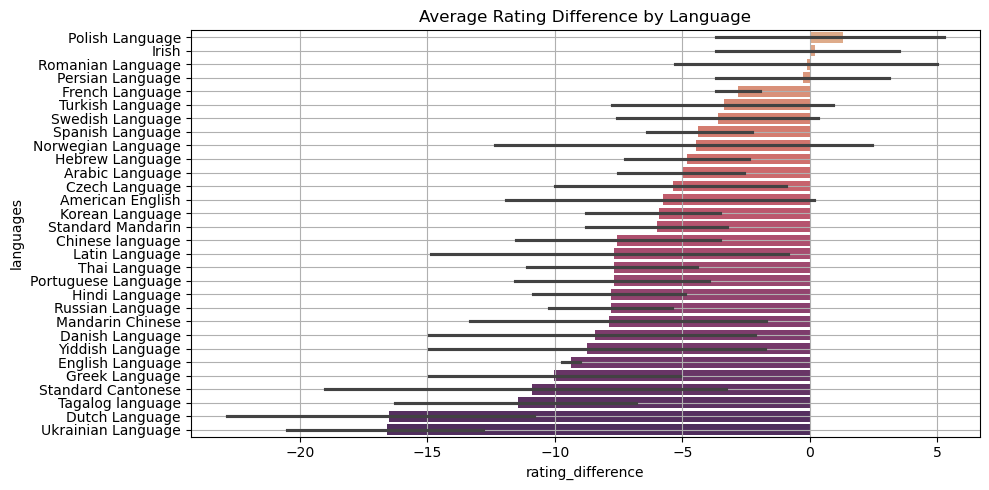

In [21]:
# Plot the barplot of rating difference per language (sorted by mean rating difference)

# Group by language and calculate average rating_difference for each language
language_scores = df_language.groupby('languages')['rating_difference'].mean().reset_index()

if len(language_scores) > 30:
    language_scores_sorted = language_scores.sort_values(by='rating_difference', ascending=False)
    plot_results(df_language.loc[df_language['languages'].isin(pd.concat([language_scores_sorted.head(15)['languages'], language_scores_sorted.tail(15)['languages']]))], 'languages', 'rating_difference', 'Average Rating Difference by Language')
else:
    display(language_scores)
    plot_results(df_language, 'languages', 'rating_difference', 'Average Rating Difference by Language')


From the plot above, we notice that the languages with the biggest difference mostly european languages like `Ukrainian`, `Dutch`, `Greek`, etc. 
However, we can notice that the error bars are quite big, suggesting that we have large confidence intervals and we are not very confident of our results.
We should therefore continue to further explore our dataset to get to more conclusive results.

In [22]:
# Export the data to a json file
#export_json(df_language.groupby('languages')['rating_difference'].agg(['mean', 'sem', 'count']).reset_index(), 'website/public/data/languages-1.json')

### Hotencoding

One-hot encoding columns are added to convert language data into a binary matrix format. A one-hot column by language is added. These columns will be useful to achieve linear regression on languages. 

In [23]:
# Hot encode languages per movie
one_hot_languages, one_hot_languages_columns = hotencode(df_language, 'languages', id_column='freebase_id', prefix='onehot-language')

# Add the rating_difference column
one_hot_languages = one_hot_languages.merge(df_language[['freebase_id', 'rating_difference']].drop_duplicates(), on='freebase_id')

print(one_hot_languages.shape)

(7312, 38)


### Pearson Correlation

We test the linear relationship between `rating_difference` and each language individually with the Pearson coefficient. We will check if the relationship is significant.

Significant results: 12/36


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Languages
onehot-language_French Language,0.139063,6.698615e-33,0.116513,0.161470,onehot-language_French Language,French Language,745,French Language
onehot-language_Persian Language,0.046056,8.160120e-05,0.023159,0.068904,onehot-language_Persian Language,Persian Language,41,Persian Language
onehot-language_Polish Language,0.037679,1.270465e-03,0.014771,0.060549,onehot-language_Polish Language,Polish Language,19,Polish Language
onehot-language_Spanish Language,0.035207,2.604184e-03,0.012295,0.058081,onehot-language_Spanish Language,Spanish Language,107,Spanish Language
onehot-language_Romanian Language,0.030181,9.854086e-03,0.007264,0.053066,onehot-language_Romanian Language,Romanian Language,17,Romanian Language
onehot-language_Japanese Language,0.027942,1.687576e-02,0.005024,0.050831,onehot-language_Japanese Language,Japanese Language,223,Japanese Language
onehot-language_Arabic Language,0.024295,3.776508e-02,0.001374,0.047190,onehot-language_Arabic Language,Arabic Language,74,Arabic Language
onehot-language_Irish,0.024063,3.962865e-02,0.001142,0.046959,onehot-language_Irish,Irish,10,Irish
onehot-language_Swedish Language,0.023578,4.379254e-02,0.000657,0.046474,onehot-language_Swedish Language,Swedish Language,33,Swedish Language
onehot-language_Ukrainian Language,-0.024953,3.287006e-02,-0.047847,-0.002032,onehot-language_Ukrainian Language,Ukrainian Language,10,Ukrainian Language


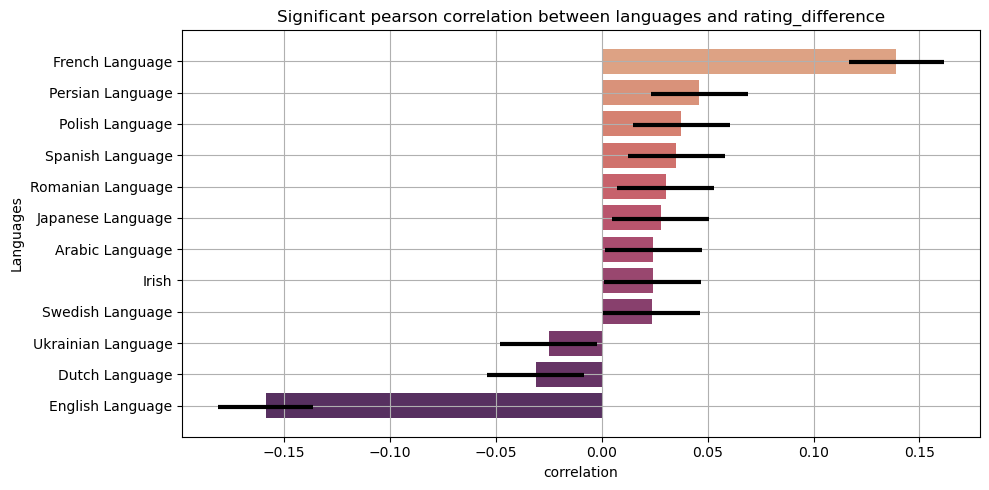

In [24]:
def map_languages_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_language[df_language['languages'] == x]))
    return df

languages_pearsonr_results, languages_pearsonr_significant = study_pearson(
    one_hot_languages,
    one_hot_languages_columns,
    'rating_difference',
    colname='Languages',
    threshold=0.05,
    print_results=True,
    title="Significant pearson correlation between languages and rating_difference",
    map_columns_name=map_languages_columns
)

For 12 languages , we can see a significatif link between the language and the rating difference. The sign of the correlation depends on the language: it's positive for languages like `French` and `Persian` but negative for others, like `English`.

In [25]:
# Export the data to a json file
#export_json(languages_pearsonr_results, 'website/public/data/languages-2.json')

### OLS
Now, we perform an OLS regression with all languages. 

In [26]:
languages_ols_results, languages_ols_significant = study_OLS(
    one_hot_languages,
    one_hot_languages_columns,
    'rating_difference',
    colname='Languages',
    regularization='l1',
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='OLS - Languages',
    map_columns_name=map_languages_columns
)

/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Dep. Variable:,rating_difference,R-squared:,0.034
Model:,OLS,Adj. R-squared:,0.029
Method:,Least Squares,F-statistic:,7.228
Date:,"Thu, 21 Dec 2023",Prob (F-statistic):,3.83e-34
Time:,11:33:37,Log-Likelihood:,-28825.
No. Observations:,7312,AIC:,5.772e+04
Df Residuals:,7276,BIC:,5.797e+04
Df Model:,35,,
Covariance Type:,nonrobust,,


Omnibus:,54.759,Durbin-Watson:,1.895
Prob(Omnibus):,0.000,Jarque-Bera (JB):,53.256
Skew:,-0.187,Prob(JB):,2.73e-12
Kurtosis:,2.811,Cond. No.,1.37e+08




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.033601,0.028952,10.067597,155.475162
baseline,0.0,0.0,10.266787,160.880941
improvement,inf,inf,-1.94%,-3.36%


Significant results: 0/36


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Languages


No results to plot


The OLS regression results indicate that languages explain only 3.4% of the variance in the rating difference between critics and audiences, suggesting limited predictive power. Despite the statistical significance of the model, evidenced by the F-statistic, no individual languages are significantly associated with the outcome. 

In [32]:
# Export the data to a json file
#export_json(languages_ols_results, 'website/public/data/languages-3.json')

In [ ]:
# save all imdb_ids per language
df_language \
    .loc[df_language['languages'].isin(languages_ols_results['Languages'])]  \
    .groupby('languages') \
    .apply(lambda x: x['imdb_id'].tolist()) \
    .to_json('website/public/data/playground-languages.json')
